In [22]:
push!(LOAD_PATH,"../src/")
using UniversalDiffEq

# Building UDEs with `UniversalDiffEq.jl`

`UniversalDiffEq.jl` can be combined with `ComponentArrays.jl` and `Lux.jl` to build and fit universal differntial equations. The user spcifies the model parameters and funcitonal forms using `ComponentArrays.jl` and `Lux.jl` and `UniversalDiffEq.jl` will build a taining routine and fit the model to a data set.  

To illustrate how this can work we build a UDE model to describe a predator-prey interactions and fit is to a data set simulated from the Loka Volterra predatory prey model. The Loka Volteraa equaitosn describe the abundances of a prey $N$ that grows at a rate $r$ in the absence of the predator and the adundance of a predator $P$ the dies at a rate $m$ in the absence of the prey. The predatory consume the prey at a rate $\alpha$ and conver prey into predator biomass at a rate $\theta$. These assumptions yield a system of ODEs that describe changes in each popualtion's abundance

$$
\frac{dN}{dt} = rN - \alpha NP \\
\frac{dP}{dt} = \theta \alpha NP - mP.
$$

One significant assumption of this model that we want to relax in our the UDE model is the linearity of the interaction term $\alpha N P$. To allow for nonlinearity we can replace this term with a neural network to represent the consumption rate as a non-linear function of predators or prey

$$
\frac{dN}{dt} = rN - NN(N,P;w,b) \\
\frac{dP}{dt} = \theta NN(N,P;w,b)  - mP.
$$

## Building the model

We will use the `Lux.Chain` function to implement the neural network. Because the funtion we are trying to learn is likely to be reletivel simple, we will use network with a single dense layer. This type of neualr network is highly flexible and can represent any nonlinear function that may eist in the data.  

The network has two inputs, the abundance of the predator $P$ and abundance of the prey $N$ and one output, the consumption rate. We also need to specify the number of units in the hidden layer, here we use ten which seems to be a good choice for simple models, and the nonlinearity. We use the `tanh` function, which also performas well in simple models like this one. 

The following cell build the neurla network using the `Lux.jl` package. The `Dense` funciton builds the dense network layers, and the `Chain` function links them together into a single model. 

In [23]:
using Lux
dims_in = 2
hidden_units = 10
nonlinearity = tanh
dims_out = 1
NN = Lux.Chain(Lux.Dense(dims_in,hidden_units,nonlinearity),
                Lux.Dense(hidden_units,hidden_units,nonlinearity),
                Lux.Dense(hidden_units,dims_out))

Chain(
    layer_1 = Dense(2 => 10, tanh_fast),  # 30 parameters
    layer_2 = Dense(10 => 10, tanh_fast),  # 110 parameters
    layer_3 = Dense(10 => 1),           # 11 parameters
)         # Total: 151 parameters,
          #        plus 0 states.

Lux neural networks take three argumnts, the inputs the model parameters and states. We can initlaize the model state and paramters using the `Lux.setup` function. 

In [24]:
using Random
rng = Random.default_rng() 
NNparameters, NNstates = Lux.setup(rng,NN) 

((layer_1 = (weight = Float32[-0.5149251 0.5008789; -0.10462466 0.122681126; … ; 0.06368262 0.44790947; 0.48916948 0.112559564], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.02681942 0.25734612 … -0.45354828 -0.31121838; 0.22309877 0.50939083 … 0.10992031 0.02801501; … ; 0.40258282 0.075328335 … -0.29015258 -0.24260294; 0.042753216 -0.46206355 … -0.31907058 0.077682495], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.5377603 -0.65420127 … -0.18513651 0.6542859], bias = Float32[0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

Now that we have the neural network for the consumption rates we need to define the rest of the model. We do this with a function named `derivs!(du,u,p,t)`, a function that updates the vector `du` with the value of the right hand side of a system of differntial equations. The vector `u` is the value of the state variables, `p` is a NamedTuple with the model parameters, and `t` is time. 

The following cell defines a derivs function based on eqautions 3 and 4. 

In [25]:
function derivs!(du,u,p,t)
    C, states = NN(u,p.NN, NNstates) # NNstates are
    du[1] = p.r*u[1] - C[1]
    du[2] = p.theta*C[1] -p.m*u[2]
end

derivs! (generic function with 1 method)

Next we need to define the initial value of the model paramters using a NamedTuple. NamedTuples are type of data structure in julia that links the value in a listed to a string. The value of each element is accessed by typing the name of the NamedTuple, a period, and then the name of the variable. NamedTuples are defined using parenthases, with the name and value of each element sperated by an eqauls sign. For example, we can dfined a NamedTupe `p` with two values `r=1` and `K=10` as follows:

```julia
p = (r=1.0,K=10.0)
```

For the UDE model we need to define a NamedTuple with the growth rate `r`, mortality rate `m`, and conversion efficency `theta` and the neular network paramters `NN`.

In [26]:
init_parameters = (NN = NNparameters,r = 1.0,m=0.5,theta=0.5)

(NN = (layer_1 = (weight = Float32[-0.5149251 0.5008789; -0.10462466 0.122681126; … ; 0.06368262 0.44790947; 0.48916948 0.112559564], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.02681942 0.25734612 … -0.45354828 -0.31121838; 0.22309877 0.50939083 … 0.10992031 0.02801501; … ; 0.40258282 0.075328335 … -0.29015258 -0.24260294; 0.042753216 -0.46206355 … -0.31907058 0.077682495], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.5377603 -0.65420127 … -0.18513651 0.6542859], bias = Float32[0.0;;])), r = 1.0, m = 0.5, theta = 0.5)

Now we can use the `CustomDerivatives`  in the `UniversalDiffEq.jl` library to build the model. This funtion takes three primary arguments, a data set, the model derivatives and the initial paraemters. The data set is a DataFrame object with time in a column labeled `t` and the remianing colums the values of the state variables. The `LokaVolterra` function produces a simulated data set simulated from the Lotka Volterra model that has 60 observations. Here we use the first 40 time points to train the model and the final 20 to test the model. 

In [27]:
data,plt=UniversalDiffEq.LokaVolterra()
training_data = data[1:(end-21),:]
testing_data = data[(end-20):end,:]
training_data[1:4,:]

Row,t,x1,x2
,Float64,Float32,Float32
1,0.0,1.06062,0.457922
2,0.0508475,0.993459,0.458054
3,0.101695,1.20552,0.462746
4,0.152542,1.24914,0.400984


In [28]:
model_1 =UniversalDiffEq.CustomDerivatives(training_data,derivs!,init_parameters)
nothing

Invalid regularization type - defaulting to L2


## Model fitting 
`UniversalDiffEq.jl` provides two optimization algorimths to train the models ADAM and BFGS. ADAM is a gradient decent algorithm that only uses first order information, BFGS also uses the second derivative to increase the accuracy of the optimization. ADAM is implemented using the `gradient_decent!` function and BFGS is implemented using the `BFGS!` function. In general running `gradient_decent!` and then `BFGS!` produces good results. 

In [29]:
UniversalDiffEq.gradient_decent!(model_1,verbos = true)

InterruptException: InterruptException:

In [30]:
UniversalDiffEq.BFGS!(model_1,verbos = true)

InterruptException: Error trying to display an error.

## Checking the model fits 
The package has built in methods for visulaizing the model fits. The `plot_state_estiamtes` function  comares the estimated state varaibles $\hat{u}_t$ to the data $x$. It is best practice to check the fit of the state estimtes before other performance tests, because the models predictions will not be meaningfull if the state estiateates are very poor.

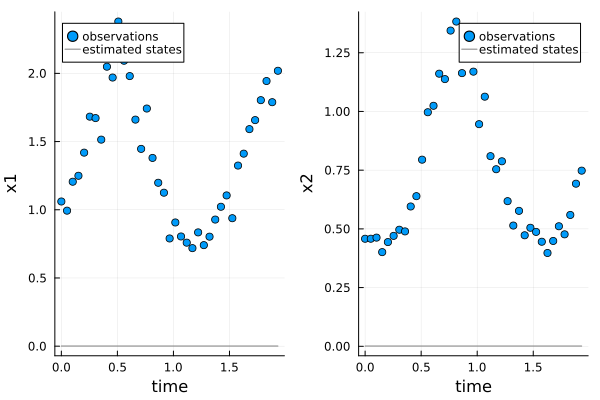

In [31]:
UniversalDiffEq.plot_state_estiamtes(model_1)

We can check the in sample model predictions with the `plot_predictions` function. Function compares the cahnge in the state variables predicted to the model to the observed chagnes in the estiamted state varaibales $\hat{u}_t$.

In [32]:
UniversalDiffEq.plot_predictions(model_1)

InterruptException: InterruptException:

## Testing out of sample performance

Earlier we split the data into a training and testing data set by leaving out the final 15 observaitons. We can compare the the model predictions to the out of sample data using the `plot_forecast` function. This functions starts at the end point of the training data and forecasts the entier length of the test data. It then plots the model forecast to the observed data.

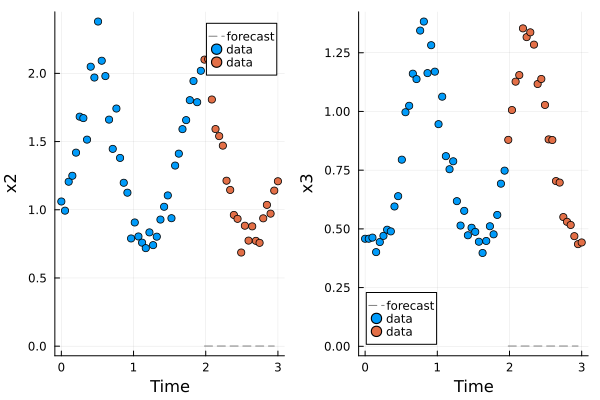

In [33]:
plt,(p1,p2) = UniversalDiffEq.plot_forecast(model_1, testing_data)
plt

Predicting many steps into the future may be overly ambitions in many cases. Under these curcumstances we can test the models ability to predict the next data point in the test data by supplying a test data set to the `plot_predictions` function. Note that the prefornace on test data will generally be poor than the training data becasue they include observation errors. 

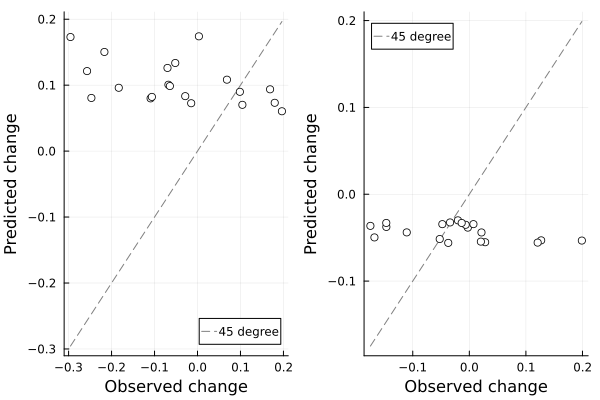

In [34]:
UniversalDiffEq.plot_predictions(model_1, testing_data)

## Modifying model fitting with key word arguments 
An important factor in model performance is loss function. The loss function compares the model predictions to the data and is the target of the optimizaiton algorithms in the model fitting process. The loss functions generated by `UniversalDiffEq.jl` account for observaiton errors, and allow the user to regularize the neural network. Both of these steps reduce over fitting and can improve performance on out of sample observations. The level of observaiton error and regularization are controled by changing three key work arguments, `proc_weight`, `obs_weight`, and `reg_weight`.  Larger values of `proc_weight` and smaller values of `obs_weight` increase the amount of observation error expected by the model. They default to 1 if not provided. In this example I set `proc_weight` to 2.0 and `obs_weight` to 0.5. `reg_weight` defaults to zero, I increased it to $10^{-4}$ for this example.

In [35]:
model_2 = CustomDerivatives(training_data,derivs!,init_parameters,proc_weight = 2.0, obs_weight = 0.5, reg_weight = 10^-4)
nothing

Invalid regularization type - defaulting to L2


In [36]:
gradient_decent!(model_2,verbos = true)

InterruptException: InterruptException:

In [37]:
BFGS!(model_2,verbos = true)

InterruptException: InterruptException:

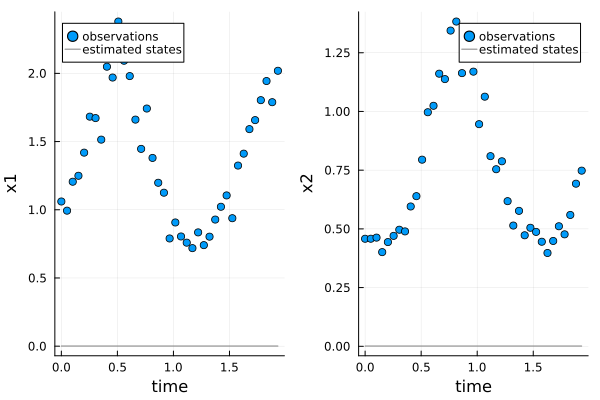

In [38]:
plot_state_estiamtes(model_2)

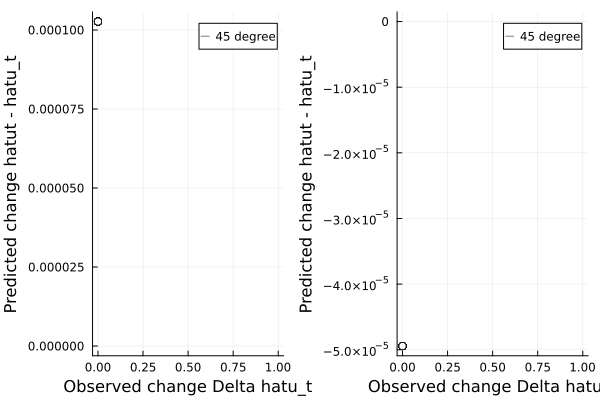

In [39]:
plot_predictions(model_2)

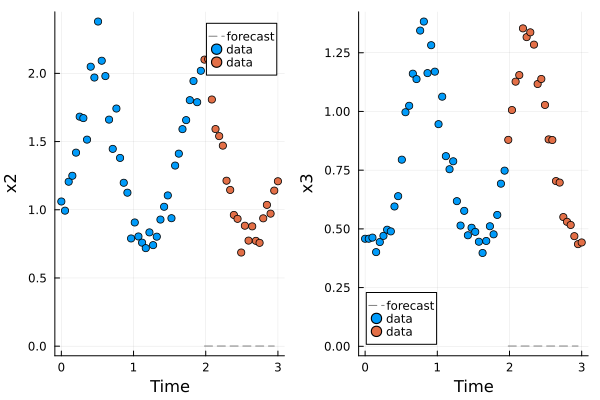

In [40]:
plt,(p1,p2) = plot_forecast(model_2, testing_data)
plt

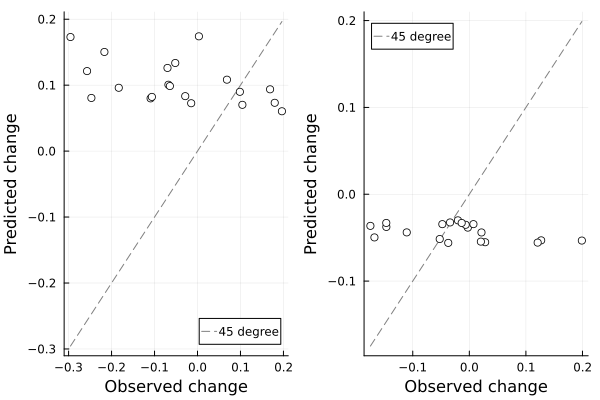

In [41]:
plot_predictions(model_2, testing_data)